## Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import math

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#custom modules
import wrangle
import new_wrangle

#sklearn preprossing, clustering and modeling libraries
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score

#remove warnings
import warnings
warnings.filterwarnings("ignore")

## Color Palette Specs for Visualization

In [2]:
walmart_palette_c = ['#004c91', '#007dc6', '#78b9e7', '#f47321', '#ffc220', '#367c2b', '#76c043']
walmart_palette_d = ['#004c91', '#ffc220' , '#f47321', '#367c2b','#007dc6', '#76c043', '#78b9e7']
sns.color_palette(walmart_palette_c)
sns.set_palette(walmart_palette_d)
sns.color_palette(walmart_palette_d)

[(0.0, 0.2980392156862745, 0.5686274509803921),
 (1.0, 0.7607843137254902, 0.12549019607843137),
 (0.9568627450980393, 0.45098039215686275, 0.12941176470588237),
 (0.21176470588235294, 0.48627450980392156, 0.16862745098039217),
 (0.0, 0.49019607843137253, 0.7764705882352941),
 (0.4627450980392157, 0.7529411764705882, 0.2627450980392157),
 (0.47058823529411764, 0.7254901960784313, 0.9058823529411765)]

<hr style="border:2px solid blue"> </hr>

# Acquire

In [13]:
# Import data
df= new_wrangle.acquire_data()

Data Acquisition - Key Findings & Takeaways:
* Data sets provided in two .csv files that are merged into one dataframe for the project


<hr style="border:2px solid blue"> </hr>

# Prepare

In [14]:
# Execute preparation function
data=new_wrangle.wrangle_walmart()

Data Preparation - Key Findings & Takeaways:
* basic clean consisted of lowercasing features, renaming columns, converting selected dtypes appropriately, rounding decimals and converting date object into datetime 
* identified a handful of outliers based on store type and weekly sales data and decided to reclassify store type in accordance with prevailing weekly sales threshold
* feature engineering:
    * added feature labeling holiday by Date: Super Bowl, Labor Day, Thanksgiving and Christmas
        * additional column created with dummy variables for the holidays
        * labels were shifted ahead by 1 time period to capture impact of holiday sales buildup
    * created additional feature containing the following week's 52 week (1yr) weekly sales lookback by shifting up weekly sales by 51 periods
    * set index using (current Date) + (store number) + (week+1 Date)
    * Target: weekly sales shifted back 1 time period to be regressed on observation features from previous week

### Data Split

In [17]:
train, test = new_wrangle.split_scale(data, 'next_week_sales_target', scaler = None)

train -> (2866, 17)
test -> (1229, 17)


<hr style="border:2px solid blue"> </hr>

# Explore

In [19]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')

#### Bivariate Exploration

Text(0.5, 1.0, 'Store Type by Size')

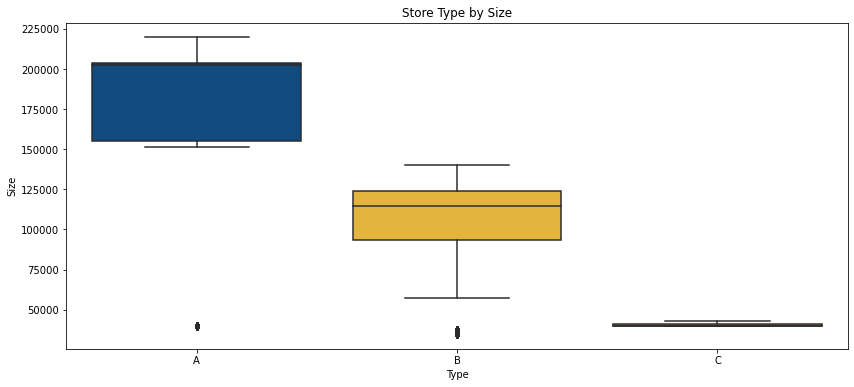

In [22]:
#visualize store_type by store_size
plt.figure(figsize=(14, 6))
sns.boxplot(x='Type', y='Size', data=df)
plt.title('Store Type by Size')

***
Key Findings & Takeaways:
* Store type directly related to size
    * anomalous observations in store types A & B appear more in line with store type C
        * these were: store 3, store 5, store 33, store 36 
        * instead of dropping, we decided to reclassify these and include them in our type C data
***

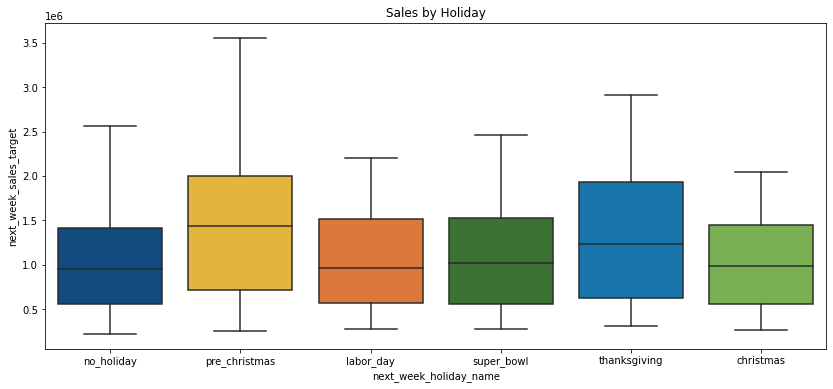

In [32]:
plt.figure(figsize=(14,6))
sns.boxplot(x= train['next_week_holiday_name'], y =train['next_week_sales_target'] )
plt.title('Sales by Holiday')
plt.show()

***
Key Findings & Takeaways:
* Our Pre_Christmas & Thanksgiving sales appear to be strong sales drivers.  
    * further investigation shows Thanksgiving sales are primarily driven by Black Friday specials
    * after noticing a run up in sales leading into the Christmas week, we created an additional feature to capture this period
        * the exploration above shows our pre_Christmas period being our strongest sales driver within these observations
            * the Christmas tag was applied to the week ending after the Christmas holiday negating the holiday impact; unlike the Thanksgiving holiday where Black Friday occurs in the same week
***